In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [2]:
fpath = './data/phase2_ground_truth.hdf'
df = pd.read_hdf(fpath)


In [3]:
df

,timestamp,value,label,KPI ID
107717,1482940800,0.048066,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107718,1482940860,0.010651,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107719,1482940920,0.014996,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107720,1482940980,0.039722,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107721,1482941040,0.022452,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
...,...,...,...,...
295409,1508984160,34.940000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295410,1508984220,35.200000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295411,1508984280,33.020000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295412,1508984340,35.150000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114


In [4]:
uuids = df.groupby('KPI ID').size()#.loc[lambda x: x>140000].sort_values().index.values

1. Drop time series with 5-min interval
2. Missing statuses are filled with adjacent periods (24 hour). Specifically, when the missing duration is less than or equal to M=7 time units, the linear interpolation is performed by filling the missing statuses with the adjacent statuses. When the missing duration is greater than M time units, the linear interpolation is performed with the status of the same time slot from the adjacent periods as shown in Fig. 2. 

![title](img/imp.png)

In [8]:
def plot_anomaly(df, num):
    t_n = df[df.label==0].index.values
    v_n = df[df.label==0].value.values
    t_a = df[df.label==1].index.values
    v_a = df[df.label==1].value.values

    fig, ax = plt.subplots(figsize=(16, 4))

    ax.plot(t_n, v_n, '.')
    ax.plot(t_a, v_a, 'o')

    ax.set(xlabel='time (s)', ylabel='value',
           title=f'ID: {num}')
    ax.grid()

    fig.savefig(f"./data/{num}.png")
    plt.show()

    
def check_missing_timestamp(df):
    missing_intervals = []
    missing_intervals_len = []
    for i in range(0, len(df)-1, 2):
        if df.timestamp.values[i] != df.timestamp.values[i+1] - 60:
            missing_intervals.append(i)
            missing_intervals_len.append((df.timestamp.values[i+1] - df.timestamp.values[i]) // 60)
    return missing_intervals, missing_intervals_len


In [9]:
def interpolate(ts, label, kpi_id, a, b):
    if np.isnan(ts[a]):
        return ts[b], label[b], kpi_id[b]
    elif np.isnan(ts[b]):
        return ts[a], label[a], kpi_id[a]
    else:
        return (ts[a] + ts[b]) / 2, max(label[a], label[b]), kpi_id[a]



def impute(df, m=7, period=60*24):
    #missing_intervals, missing_intervals_len = check_missing_timestamp(df)
    v = df.value.values
    label = df.label.values
    kpi = df['KPI ID'].values
    for i in range(len(v)):
            if not np.isnan(v[i]):
                continue
                
            # find nan window len
            i_next_not_null = i
            while i_next_not_null < len(v):
                i_next_not_null += 1
                if not np.isnan(v[i_next_not_null]):
                    break
            if i_next_not_null - i <= m:
                v[i], label[i], kpi[i]  = interpolate(v, label, kpi, i-1, i_next_not_null)
            else:
                #print(f'{i}')
                i_prev_period = i - period
                i_next_period = i + period
                while i_next_period < len(v):
                    if not np.isnan(v[i_next_period]):
                        break
                    i_next_period += period
                #print(f'start {i_prev_period} nans: {i}..{i_next_not_null}, len: {i_next_not_null - i}')
                for step in range(i_next_not_null - i):
                    try:
                        v[i+step], label[i+step], kpi[i+step] = interpolate(v, label, kpi, i_prev_period+step, i_next_period+step)
                    except:
                        break
                i = i_next_not_null + step
    df['value'] = v
    df['label'] = label
    df['KPI ID'] = kpi
    return df

0: 05f10d3a-239c-3bef-9bdc-a2feeb0037aa period: 60 sec
Total missing values: 357/149130
Longest missing interval: 2, 5, avreage interval 2.0517241379310347


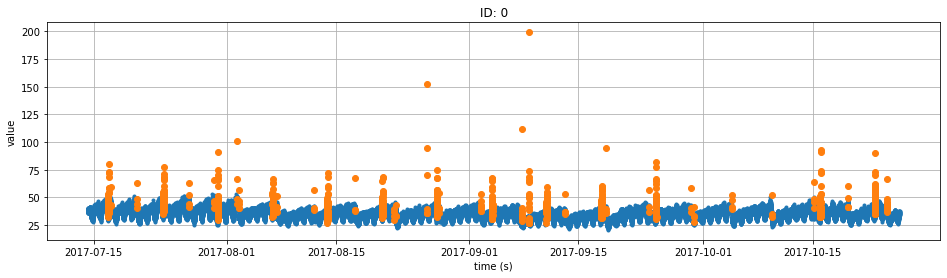

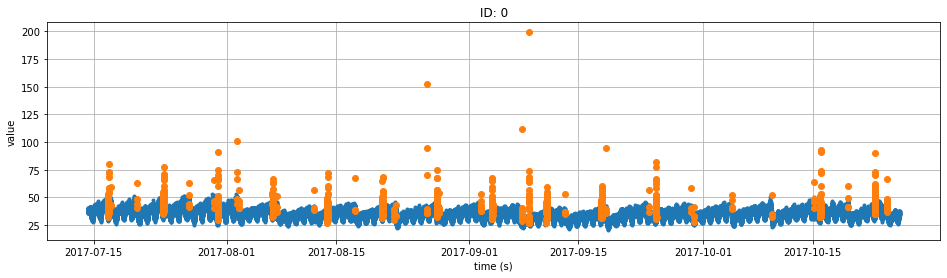

1: 0efb375b-b902-3661-ab23-9a0bb799f4e3 period: 300 sec
2: 1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0 period: 60 sec
Total missing values: 360/149156
Longest missing interval: 2, 7, avreage interval 2.0809248554913293


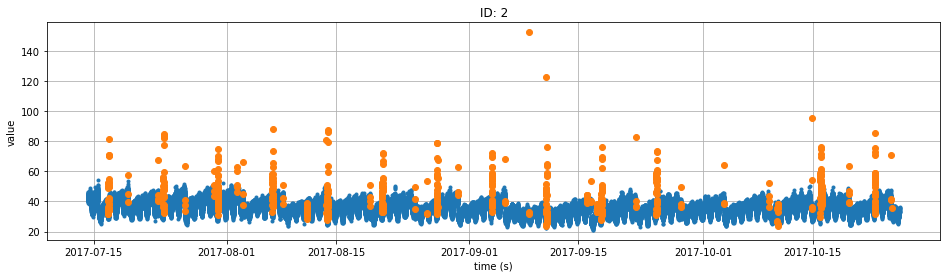

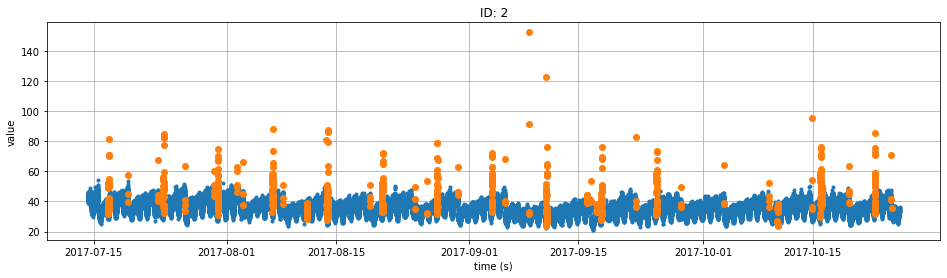

3: 301c70d8-1630-35ac-8f96-bc1b6f4359ea period: 300 sec
4: 42d6616d-c9c5-370a-a8ba-17ead74f3114 period: 60 sec
Total missing values: 349/149161
Longest missing interval: 2, 4, avreage interval 2.0409356725146197


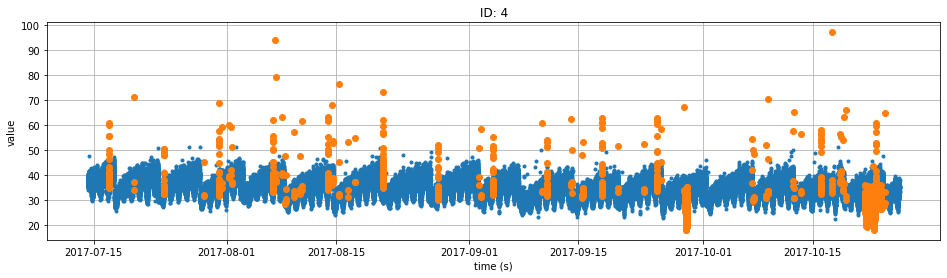

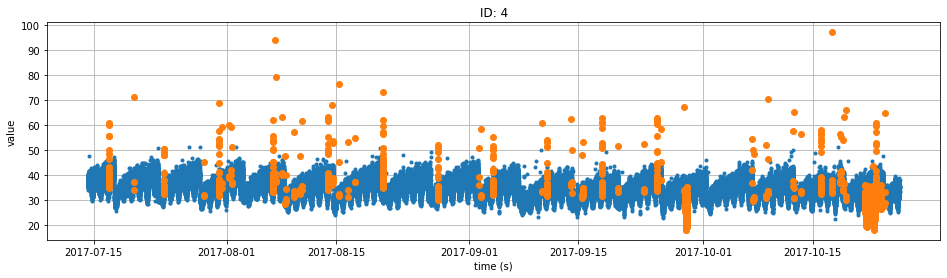

5: 43115f2a-baeb-3b01-96f7-4ea14188343c period: 60 sec
Total missing values: 48/110629
Longest missing interval: 2, 6, avreage interval 2.526315789473684


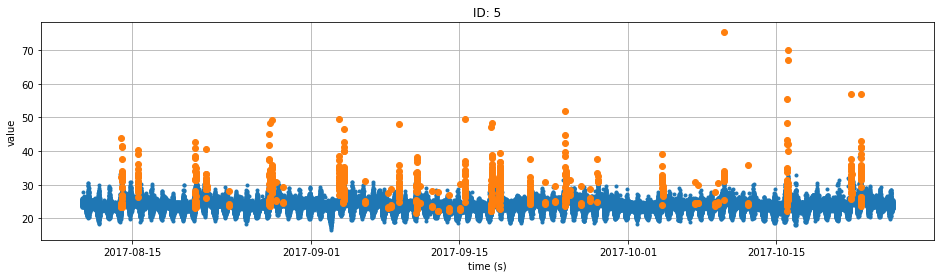

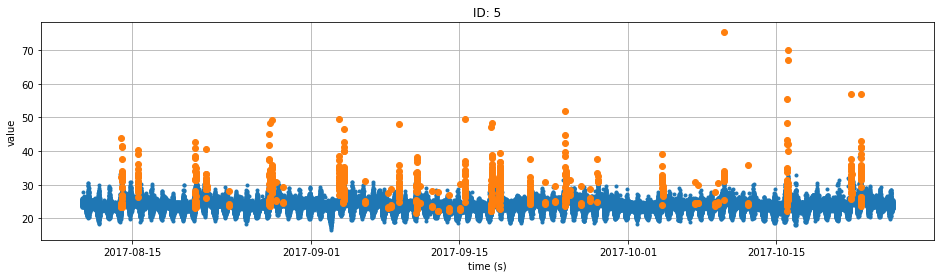

6: 431a8542-c468-3988-a508-3afd06a218da period: 60 sec
Total missing values: 16455/111566
Longest missing interval: 2, 5421, avreage interval 82.68844221105527


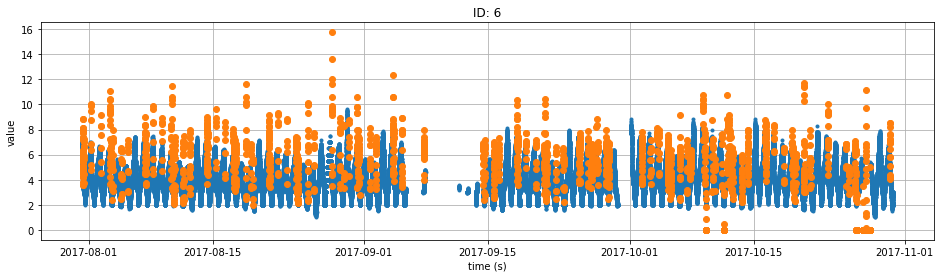

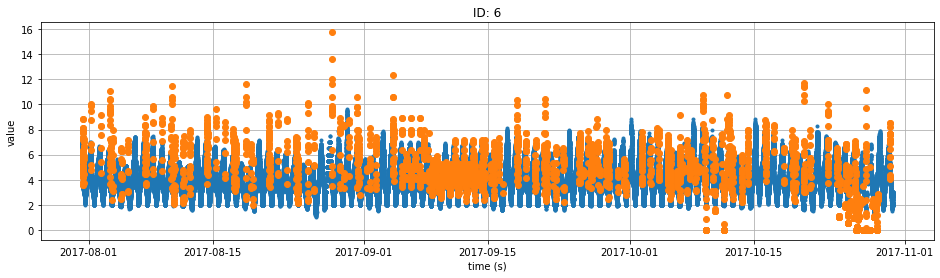

7: 4d2af31a-9916-3d9f-8a8e-8a268a48c095 period: 60 sec
Total missing values: 2124/111370
Longest missing interval: 2, 1301, avreage interval 30.782608695652176


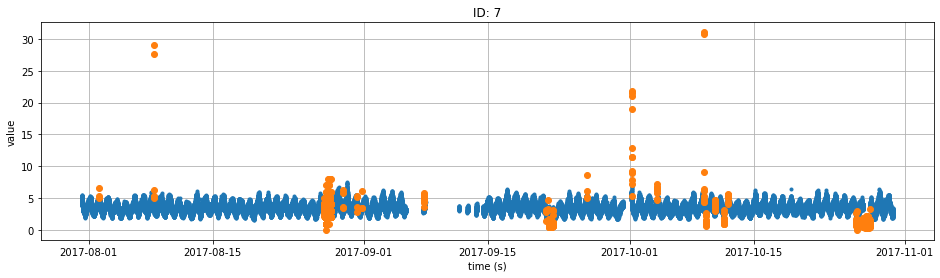

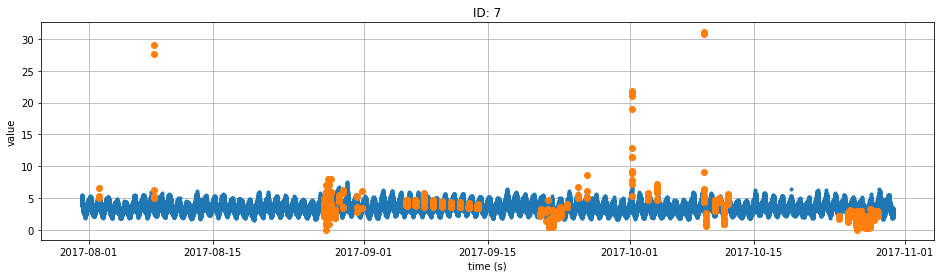

8: 54350a12-7a9d-3ca8-b81f-f886b9d156fd period: 300 sec
9: 55f8b8b8-b659-38df-b3df-e4a5a8a54bc9 period: 60 sec
Total missing values: 396/149133
Longest missing interval: 2, 6, avreage interval 2.106382978723404


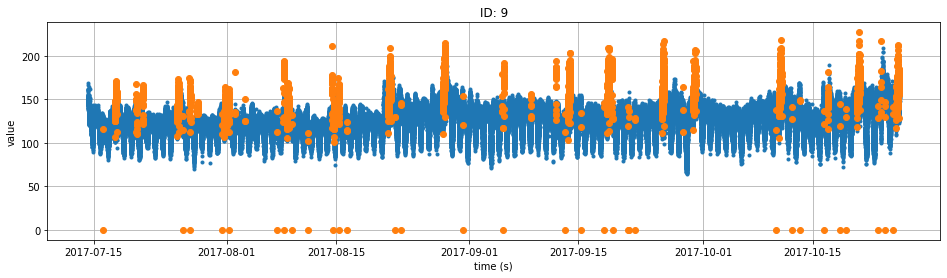

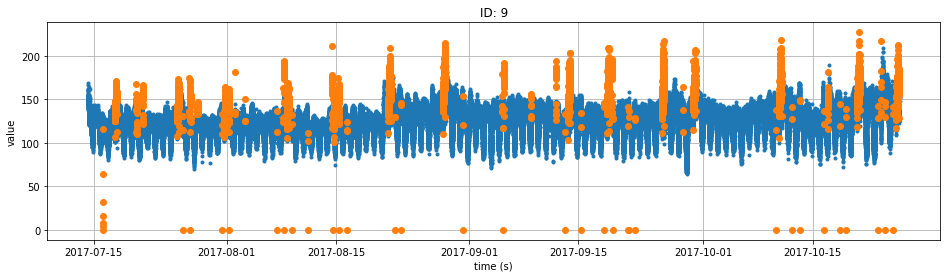

10: 57051487-3a40-3828-9084-a12f7f23ee38 period: 60 sec
Total missing values: 581/111679
Longest missing interval: 2, 53, avreage interval 12.361702127659575


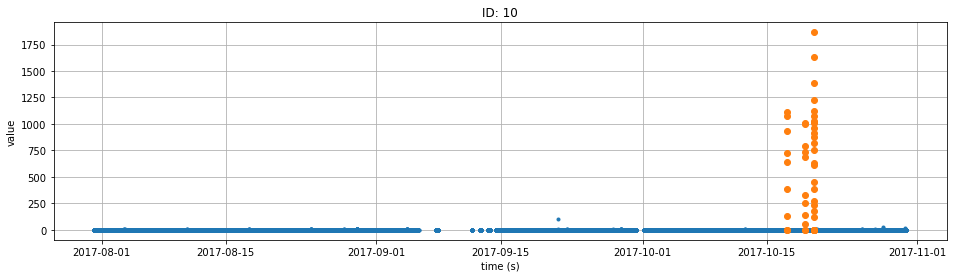

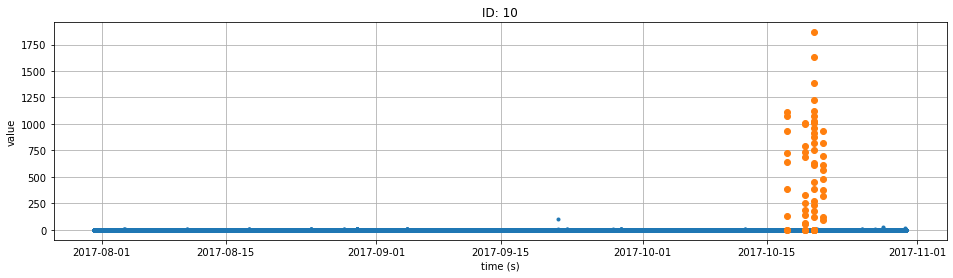

11: 6a757df4-95e5-3357-8406-165e2bd49360 period: 60 sec
Total missing values: 639/110876
Longest missing interval: 2, 53, avreage interval 15.585365853658537


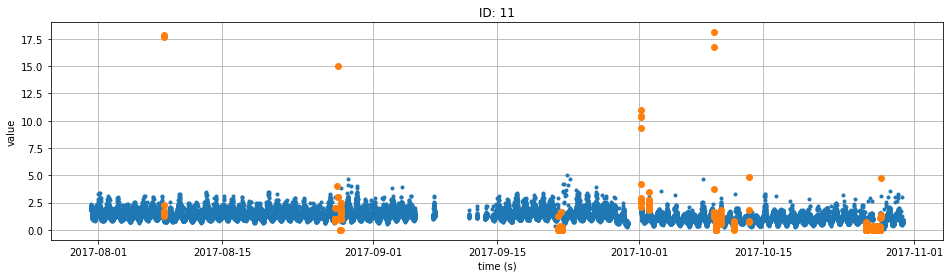

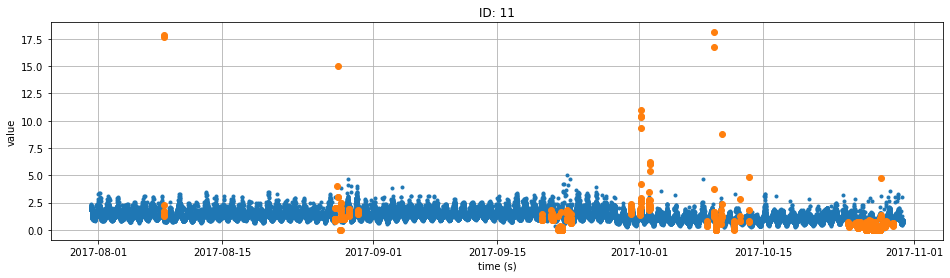

12: 6d1114ae-be04-3c46-b5aa-be1a003a57cd period: 60 sec
Total missing values: 363/149122
Longest missing interval: 2, 7, avreage interval 2.098265895953757


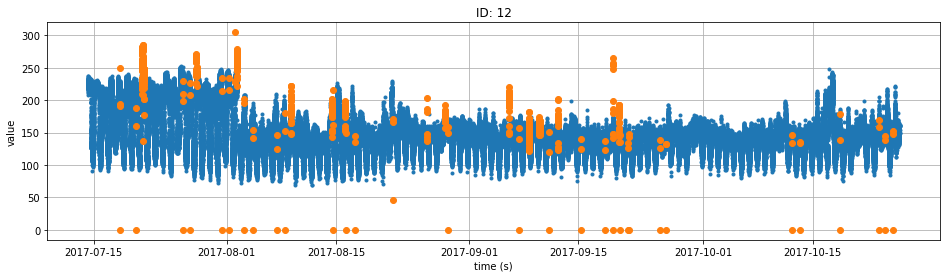

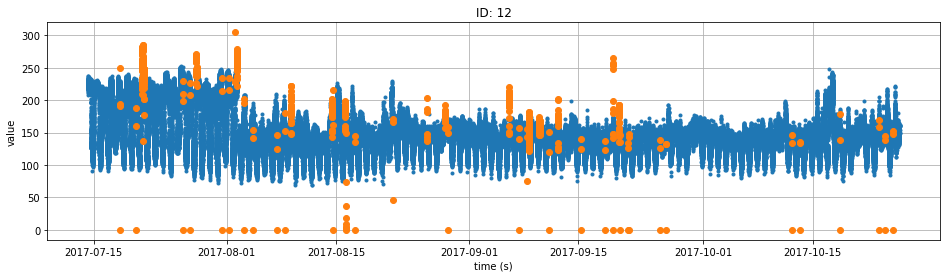

13: 6efa3a07-4544-34a0-b921-a155bd1a05e8 period: 60 sec
Total missing values: 344/149148
Longest missing interval: 2, 6, avreage interval 2.0476190476190474


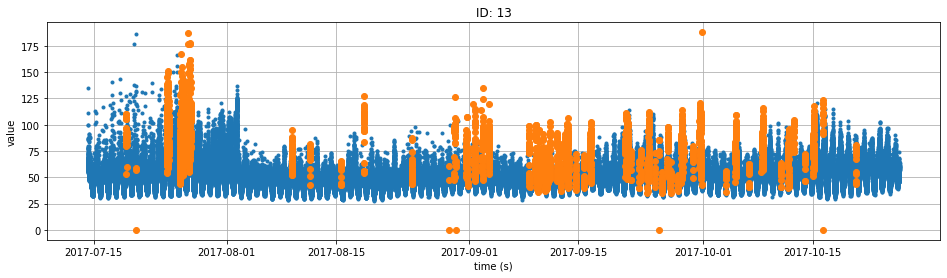

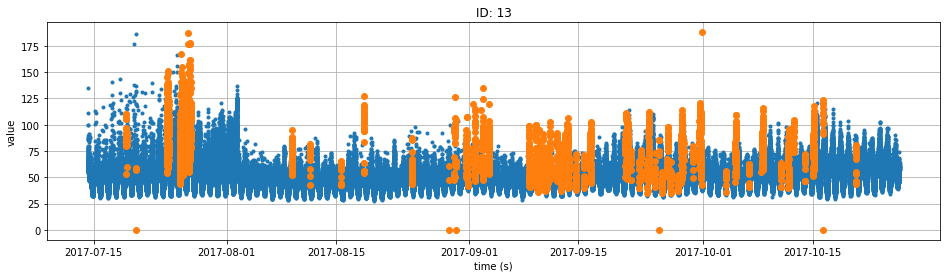

14: 7103fa0f-cac4-314f-addc-866190247439 period: 60 sec
Total missing values: 15972/108425
Longest missing interval: 2, 5421, avreage interval 63.633466135458164


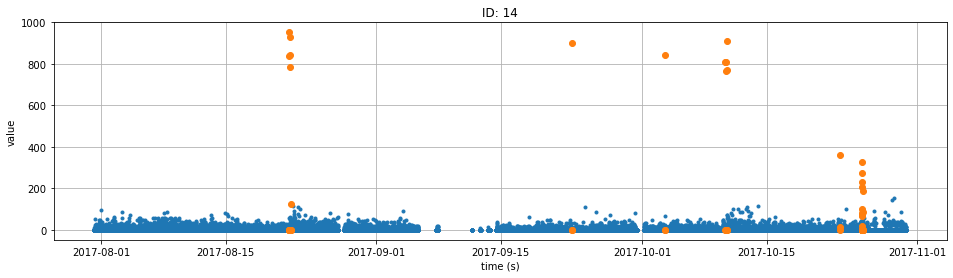

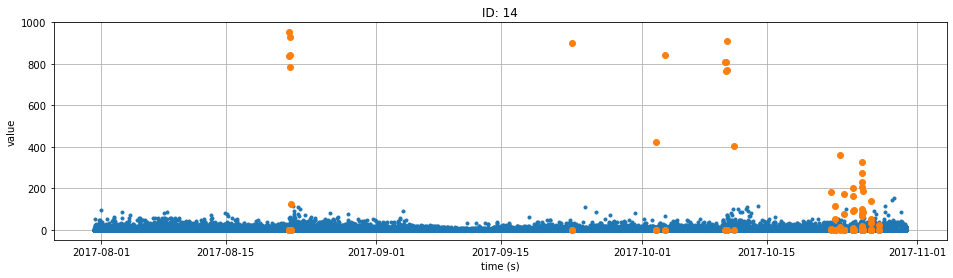

15: 847e8ecc-f8d2-3a93-9107-f367a0aab37d period: 60 sec
Total missing values: 353/149123
Longest missing interval: 2, 7, avreage interval 2.0764705882352943


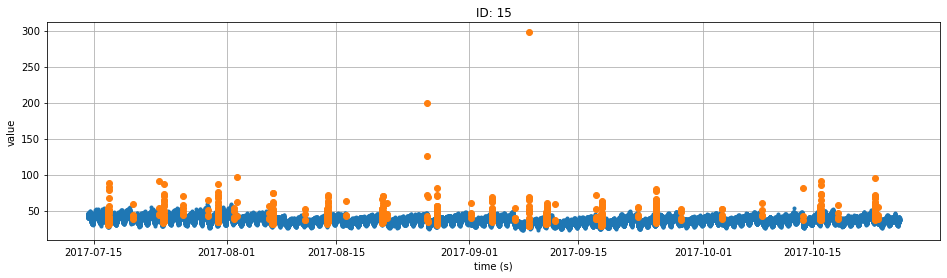

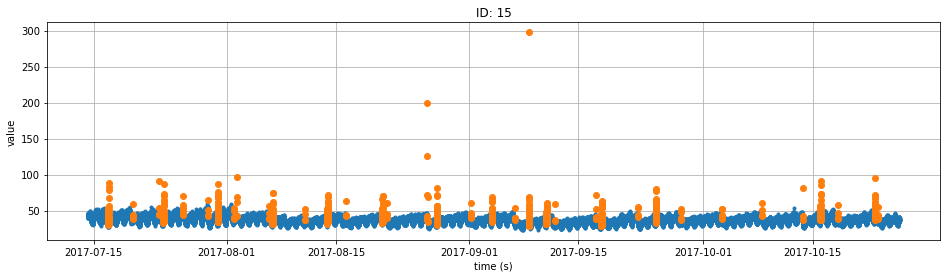

16: 8723f0fb-eaef-32e6-b372-6034c9c04b80 period: 60 sec
Total missing values: 375/149118
Longest missing interval: 2, 35, avreage interval 2.3006134969325154


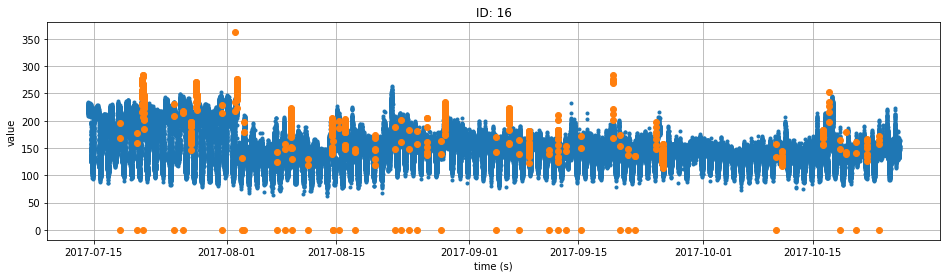

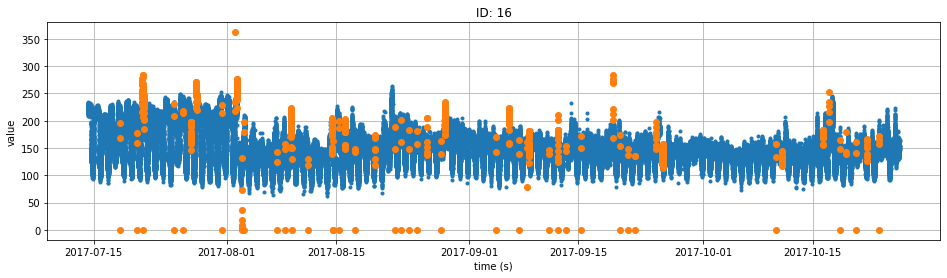

17: 9c639a46-34c8-39bc-aaf0-9144b37adfc8 period: 60 sec
Total missing values: 49/110636
Longest missing interval: 2, 7, avreage interval 2.7222222222222223


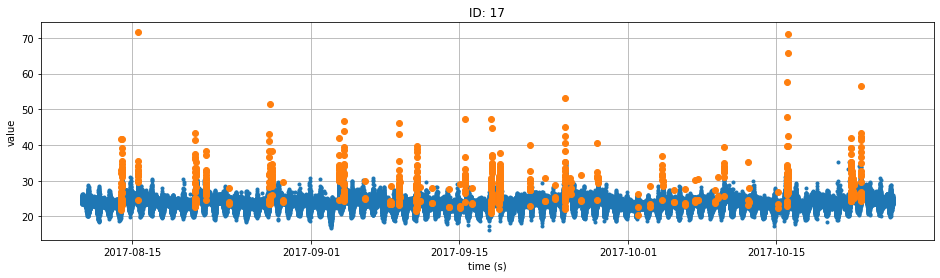

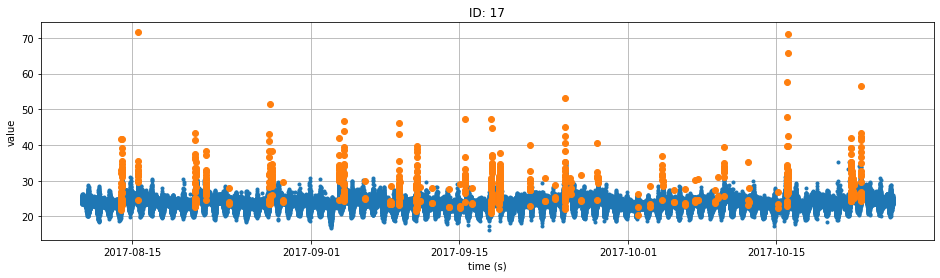

18: a07ac296-de40-3a7c-8df3-91f642cc14d0 period: 60 sec
Total missing values: 50/111307
Longest missing interval: 2, 6, avreage interval 2.272727272727273


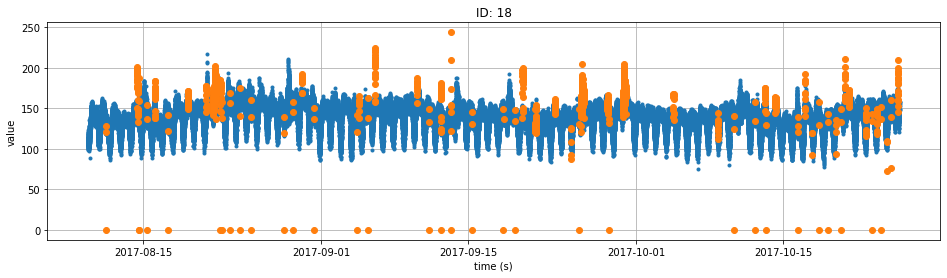

In [ ]:
num = 0
files = []
for num in range(len(uuids)):
    uuid = uuids.index[num]
    df0 = df[df['KPI ID'] == uuid]
    period = df0.timestamp.values[1] - df0.timestamp.values[0]
    print(f'{num}: {uuid} period: {period} sec')
    if (period > 60):
        continue
    missing_intervals, missing_intervals_len = check_missing_timestamp(df0)
    print(f'Total missing values: {sum(missing_intervals_len)}/{len(df0)}')
    print(f'Longest missing interval: {min(missing_intervals_len)}, {max(missing_intervals_len)}, avreage interval {np.mean(missing_intervals_len)}')
    idx = pd.to_datetime(df0['timestamp'].apply(lambda x: pd.Timestamp(x, unit='s')))
    df1 = df0.set_index(idx).loc[:,['value', 'label', 'KPI ID']].resample('1min').asfreq()#.fillna(0)
    plot_anomaly(df1, num)
    df2 = impute(df1)
    plot_anomaly(df2, num)
    num += 1
    files.append(f'./data/{num}.csv')
    df2.to_csv(f'./data/{num}.csv', sep=',')

In [679]:
files

['./data/1.csv',
 './data/3.csv',
 './data/5.csv',
 './data/6.csv',
 './data/7.csv',
 './data/8.csv',
 './data/10.csv',
 './data/11.csv',
 './data/12.csv',
 './data/13.csv',
 './data/14.csv',
 './data/15.csv',
 './data/16.csv',
 './data/17.csv',
 './data/18.csv',
 './data/19.csv',
 './data/22.csv',
 './data/23.csv',
 './data/25.csv',
 './data/26.csv',
 './data/28.csv',
 './data/29.csv']

In [118]:
!pip install sranodec

In [527]:
from sranodec import Silency



/opt/anaconda3/lib/python3.8/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


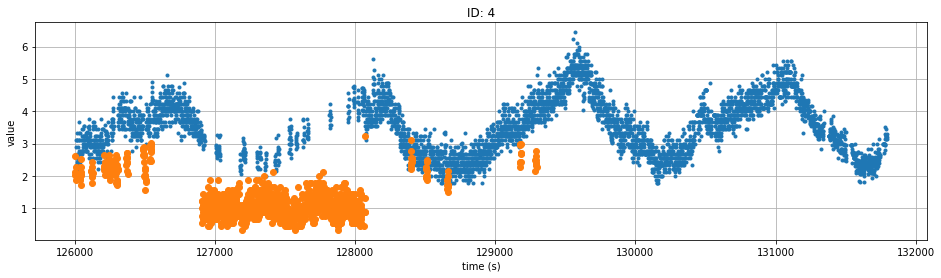

In [677]:
def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

df0 = pd.read_csv(files[5])[126000:]

w = 1440

saliency = Silency(w // 8, w // 8, w * 2)

S = np.real(saliency.transform_silency_map(df0.value.values))
S = saliency.generate_anomaly_score(df0.value.values, type='abs')

S_mean1 = moving_average(S, w)
S_mean = np.append(np.array([0] * (w // 2)), S_mean1)
S_mean = np.append(S_mean, np.array([0] * (len(S) - len(S_mean))))

#D = (S - S_mean) / S
W = 1 - 1 / (1 + np.exp(-(S - 4)))

plot_anomaly(df0, 4)

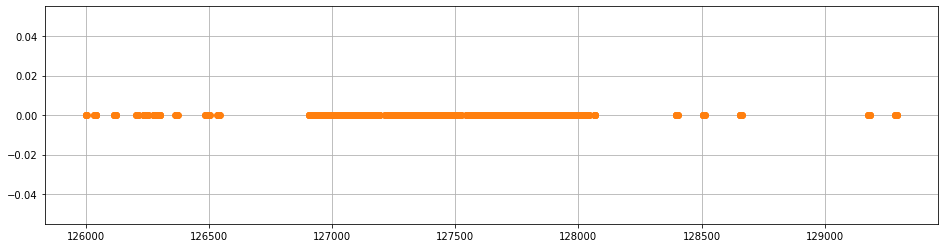

In [678]:
fig, ax = plt.subplots(figsize=(16, 4))

#plt.axis('off')
ax.plot(df0.index.values, W)
ax.plot(df0[df0.label==1].index.values, [0]*len(df0[df0.label==1]), 'o')
ax.grid()

plt.show()


In [614]:
saliency.transform_silency_map(df0.value.values)

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

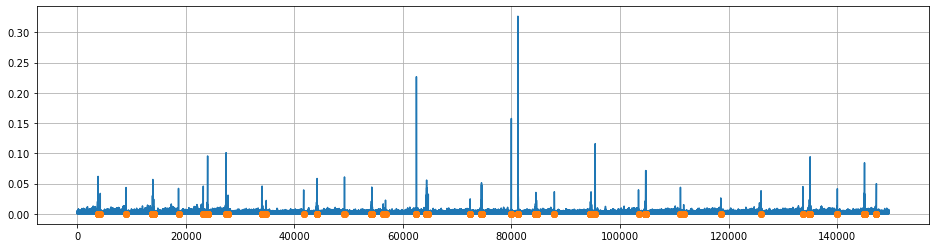

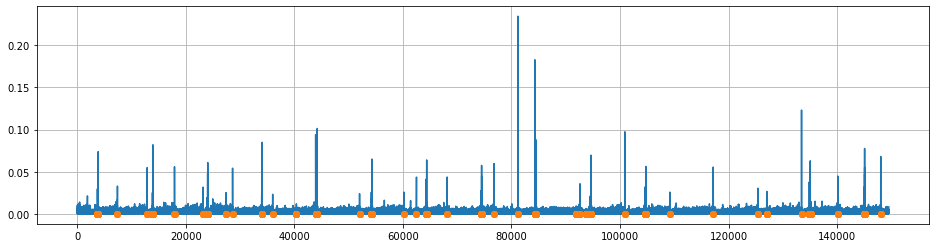

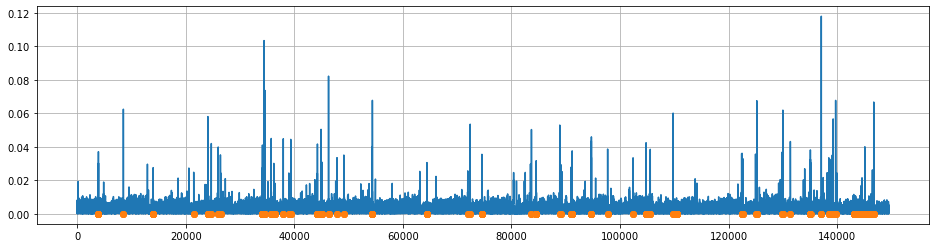

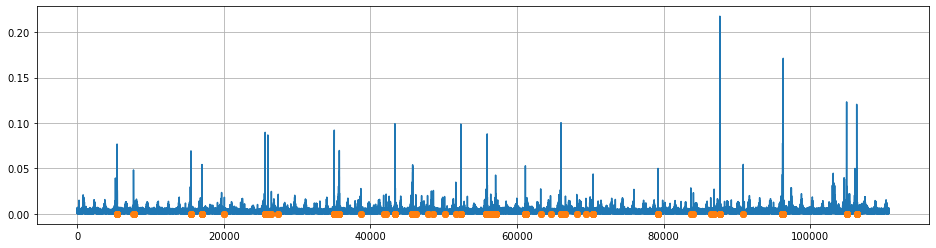

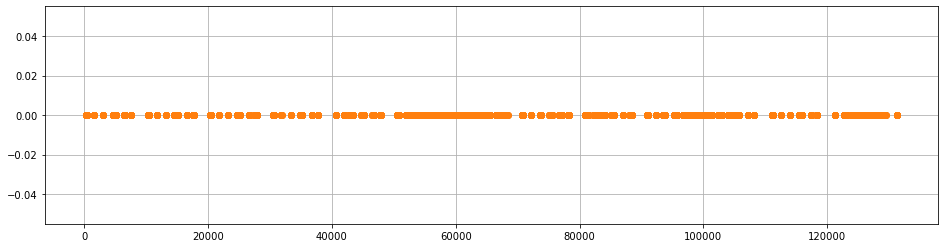

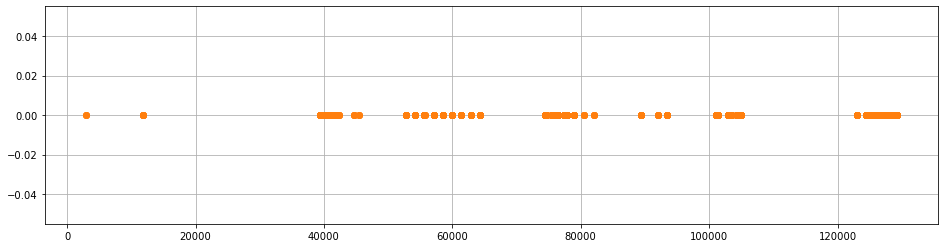

<ipython-input-631-cd917750d7e6>:19: RuntimeWarning: overflow encountered in exp
  W = 1 - 1 / (1 + np.exp(-(D - 5)))


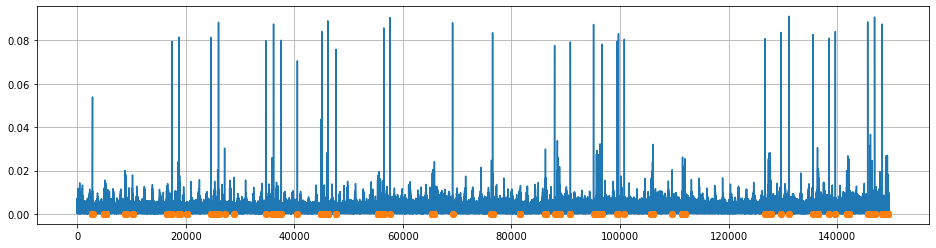

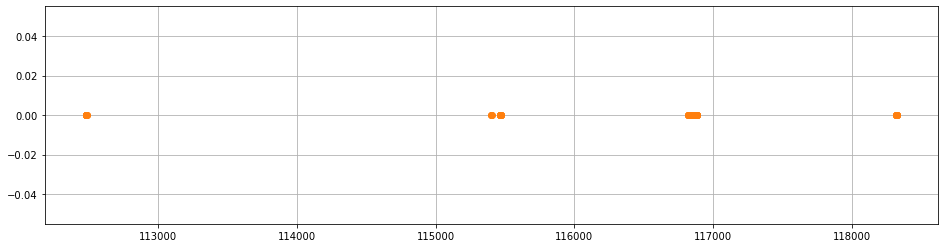

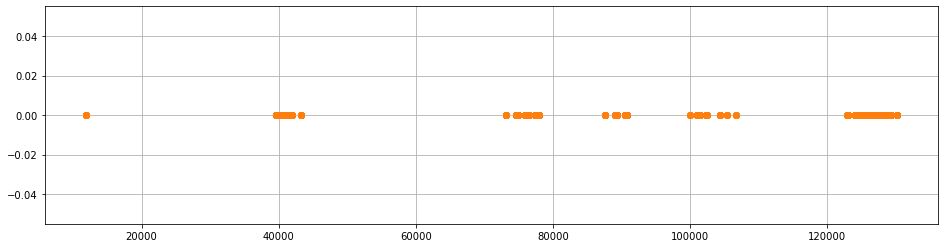

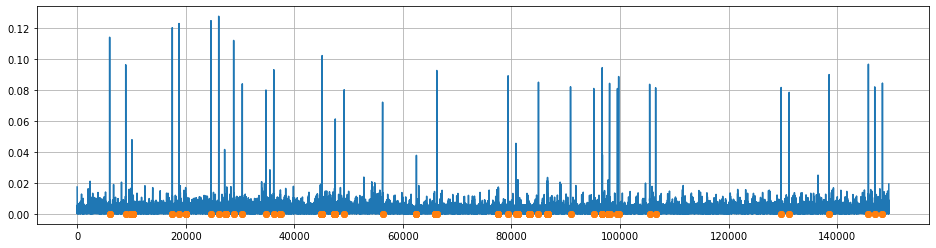

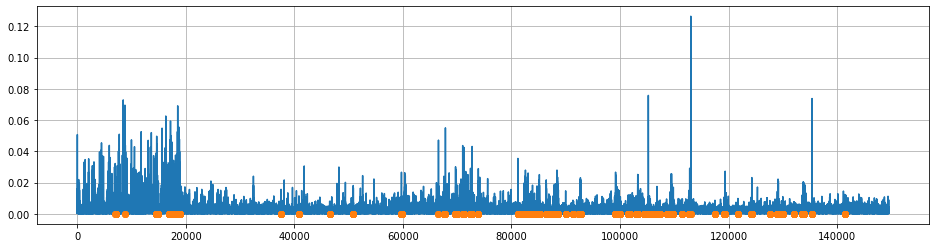

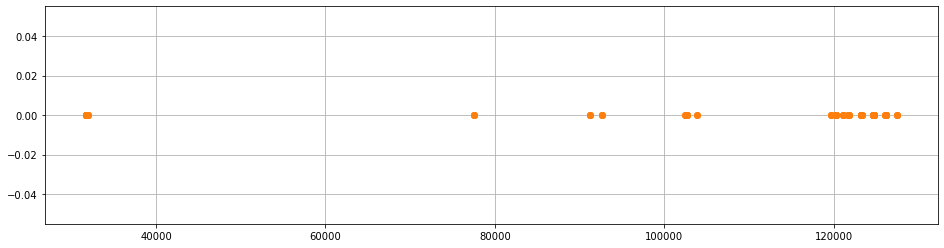

<ipython-input-631-cd917750d7e6>:19: RuntimeWarning: overflow encountered in exp
  W = 1 - 1 / (1 + np.exp(-(D - 5)))


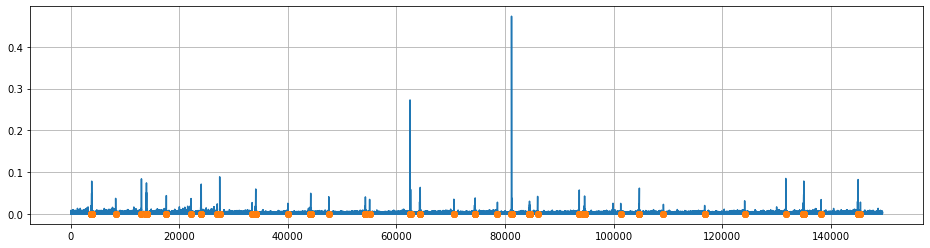

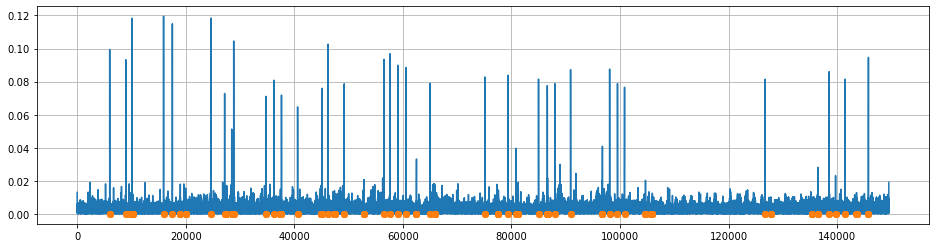

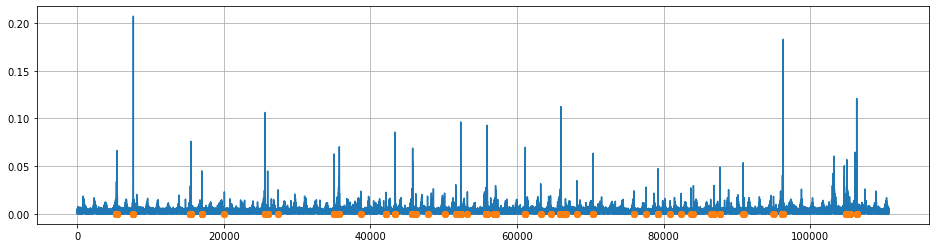

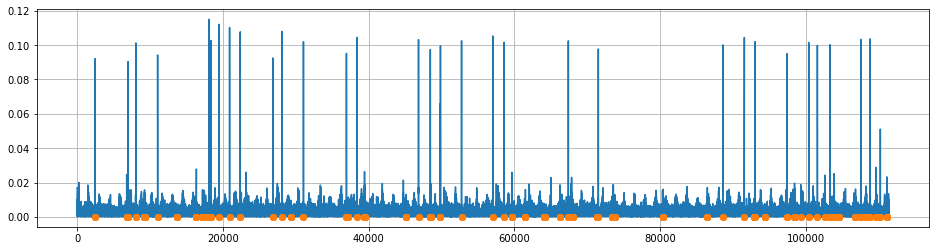

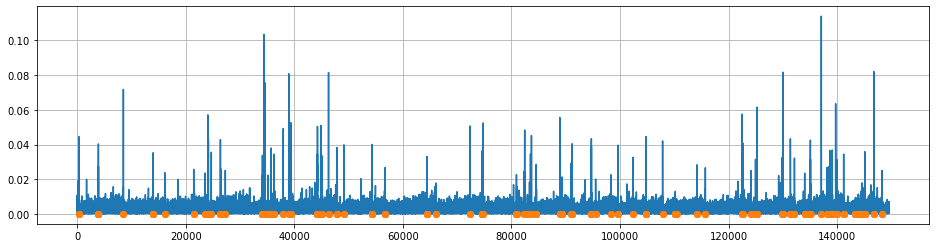

<ipython-input-631-cd917750d7e6>:19: RuntimeWarning: overflow encountered in exp
  W = 1 - 1 / (1 + np.exp(-(D - 5)))


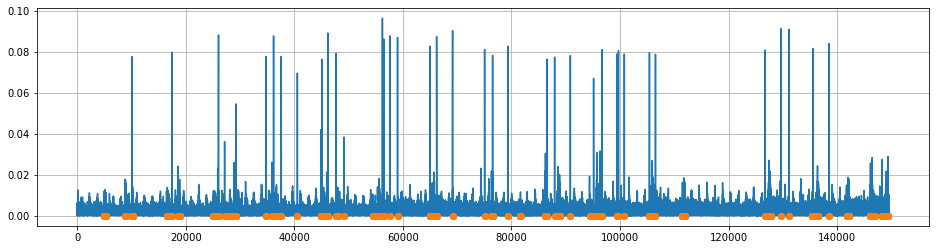

<ipython-input-631-cd917750d7e6>:19: RuntimeWarning: overflow encountered in exp
  W = 1 - 1 / (1 + np.exp(-(D - 5)))


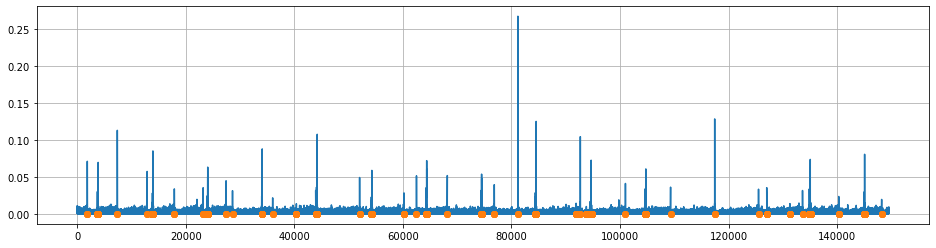

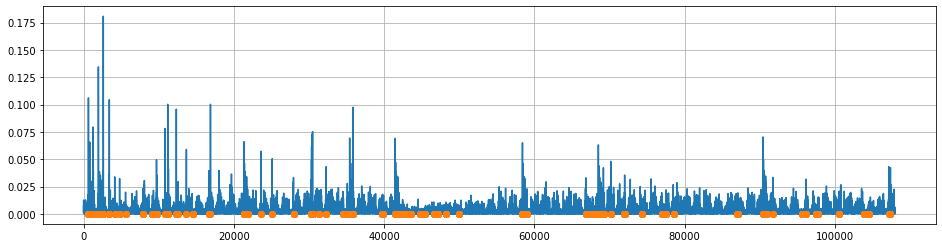

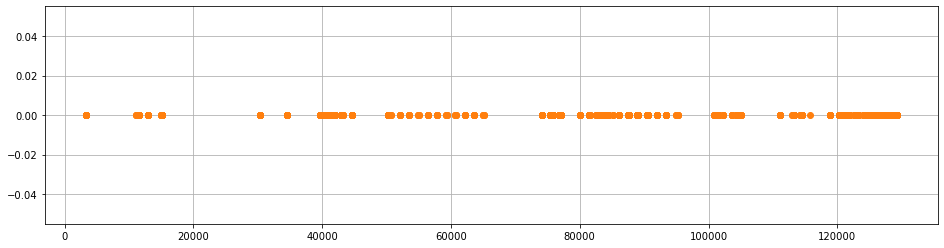

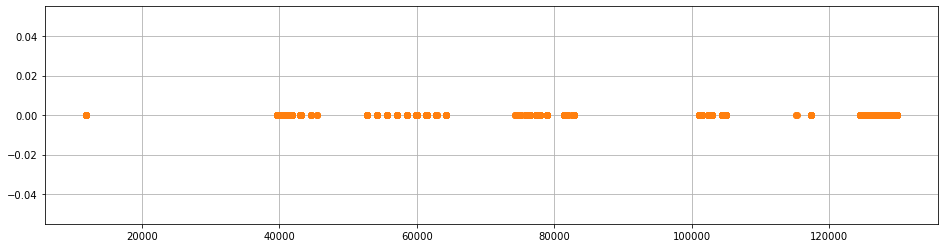

In [631]:
for file in files:
    #file = './data/1.csv'
    #df0 = df[df['KPI ID'] == uuids.index[i]]#[39000:45000]
    df0 = pd.read_csv(file)

    w = 1440
    saliency = Silency(2,2,20000)
    #S = np.real(saliency.transform_silency_map(df0.value.values))
    S = saliency.transform_spectral_residual(df0.value.values)
    
    S_mean1 = moving_average(S, w)
    S_mean = np.append(np.array([0] * (w // 2)), S_mean1)
    S_mean = np.append(S_mean, np.array([0] * (len(S) - len(S_mean))))

    #S_mean = S.mean()

    D = (S - S_mean) / S

    W = 1 - 1 / (1 + np.exp(-(D - 5)))
    W = S

    fig, ax = plt.subplots(figsize=(16, 4))

    ax.plot(df0.index.values, W)
    ax.plot(df0[df0.label==1].index.values, [0]*len(df0[df0.label==1]), 'o')
    ax.grid()

    plt.show()



In [542]:
df0[df0.label==1].timestamp.values

array([1501671540, 1501671600, 1501671660, ..., 1509159420, 1509159480,
       1509159540])

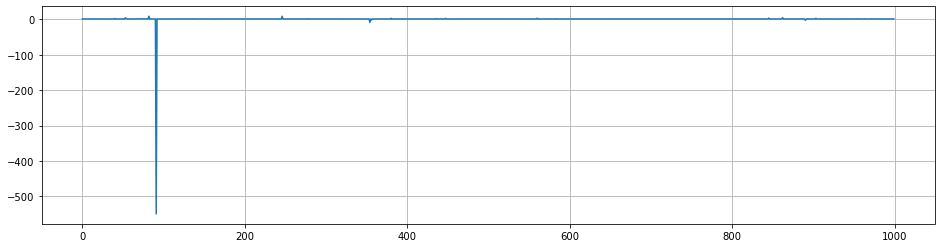

In [509]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot((S - S.mean()) / (S))
ax.grid()

plt.show()


In [266]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

S_mean1 = moving_average(S, 20)
S_mean = np.append(np.array([S_mean1[0]] * (S.shape[0] - S_mean1.shape[0])), S_mean1)

#S_mean = S.mean()

In [275]:
W

array([3.63140410e-01, 9.70041625e-01, 9.51666167e-01, 9.83901669e-01,
       9.96080686e-01, 9.96128033e-01, 9.96346072e-01, 9.92534640e-01,
       9.97620715e-01, 9.96225829e-01, 9.97122657e-01, 9.96363487e-01,
       9.97954554e-01, 9.91106303e-01, 9.97224331e-01, 9.92625331e-01,
       9.96751882e-01, 9.98579569e-01, 9.96968337e-01, 9.96174399e-01,
       9.97173085e-01, 9.94920455e-01, 9.98325369e-01, 9.99968634e-01,
       9.99549939e-01, 9.98652277e-01, 1.00000000e+00, 2.22044605e-16,
       1.94671411e-02, 3.91491371e-01, 9.99961701e-01, 9.99991336e-01,
       1.12338367e-01, 9.99116982e-01, 9.98008850e-01, 9.83648963e-01,
       9.99562042e-01, 9.89295464e-01, 9.99557693e-01, 9.97816469e-01,
       9.98960681e-01, 9.99152921e-01, 9.99892832e-01, 9.96259991e-01,
       9.98653922e-01, 9.85119554e-01, 5.61741032e-01, 9.57362615e-01,
       1.00000000e+00, 9.99999863e-01, 1.00000000e+00, 1.06565785e-02,
       5.64057037e-07, 0.00000000e+00, 2.04147363e-04, 4.46192468e-01,
      

In [278]:
np.argwhere(np.isnan(W))

array([], shape=(0, 1), dtype=int64)